# **This project aims to study how words are converted into numerical vector representations (word embeddings) in different languages and how these representations capture semantic meaning. We will generate embeddings for two languages, align their vector spaces, analyze their properties, and evaluate their usefulness in a multilingual classification task to understand how well different embedding methods model language meaning and cross-lingual relationships.**

# **Dataset Choice:**
### **We selected a large English–French parallel corpus (429,371 sentence pairs) to ensure sufficient vocabulary coverage and robust training of word embeddings across both languages. (source: https://tatoeba.org/en/downloads)**

# Step 1 — Mount Drive & Setup Environment

In [27]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install gensim fasttext scikit-learn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 1.1 — Load and Inspect Dataset

In [28]:
import pandas as pd

# Update path according to your Drive folder
file_path = "/content/drive/MyDrive/DISS/Bloc2/NLP/assignment/Sentence pairs in English-French - 2026-02-12.tsv"

df = pd.read_csv(file_path, sep="\t", header=None)
df.head()


,0,1,2,3
0,1276,Let's try something.,3091,Essayons quelque chose !
1,1276,Let's try something.,456963,Tentons quelque chose !
2,1277,I have to go to sleep.,373908,Je dois aller dormir.
3,1280,Today is June 18th and it is Muiriel's birthday!,3095,Aujourd'hui nous sommes le 18 juin et c'est l'...
4,1280,Today is June 18th and it is Muiriel's birthday!,696081,"Aujourd'hui c'est le 18 juin, et c'est l'anniv..."


### Verified dataset structure (English column, French column) and confirm clean loading.

## Step 1.2 — Separate Corpora (Separate English and French into independent corpora for embedding training.)

In [29]:
# Purpose: Separate English and French into independent corpora for embedding training.
# TSV format: col0=eng_id, col1=English, col2=fr_id, col3=French

import pandas as pd

## file_path = "/content/drive/MyDrive/your_folder/Sentence pairs in English-French - 2026-02-12.tsv"  # <-- change this

df = pd.read_csv(file_path, sep="\t", header=None)

# Separate corpora (TEXT columns)
english_raw = df.iloc[:, 1].astype(str)  # English sentence column
french_raw  = df.iloc[:, 3].astype(str)  # French sentence column

# Quick sanity check
print("English sample:", english_raw.iloc[0])
print("French sample :", french_raw.iloc[0])

English sample: Let's try something.
French sample : Essayons quelque chose !


In [30]:
# Print top 5 English sentences
print("Top 5 English sentences:")
print(english_raw.head(5).to_string(index=False))

# Print top 5 French sentences
print("\nTop 5 French sentences:")
print(french_raw.head(5).to_string(index=False))


Top 5 English sentences:
                            Let's try something.
                            Let's try something.
                          I have to go to sleep.
Today is June 18th and it is Muiriel's birthday!
Today is June 18th and it is Muiriel's birthday!

Top 5 French sentences:
                          Essayons quelque chose !
                           Tentons quelque chose !
                             Je dois aller dormir.
Aujourd'hui nous sommes le 18 juin et c'est l'a...
Aujourd'hui c'est le 18 juin, et c'est l'annive...


## 1.3 Preprocess the text - Normalize text by removing punctuation, numbers, and noise while standardizing casing. This ensures consistent vocabulary and improves embedding quality.

In [31]:
import re

def preprocess_text(text):
    text = text.lower()                              # standardize casing
    text = re.sub(r"[^\w\sà-ÿ']", " ", text)         # keep letters, numbers & apostrophes
    text = re.sub(r"\s+", " ", text)                 # normalize spaces
    return text.strip()

english_clean = english_raw.apply(preprocess_text)
french_clean  = french_raw.apply(preprocess_text)

# preview cleaned text
print("English sample:")
print(english_clean.head(5).to_string(index=False))

print("\nFrench sample:")
print(french_clean.head(5).to_string(index=False))


English sample:
                            let's try something
                            let's try something
                          i have to go to sleep
today is june 18th and it is muiriel's birthday
today is june 18th and it is muiriel's birthday

French sample:
                            essayons quelque chose
                             tentons quelque chose
                              je dois aller dormir
aujourd'hui nous sommes le 18 juin et c'est l'a...
aujourd'hui c'est le 18 juin et c'est l'anniver...


## 1.4 Tokenization - Split sentences into individual words (tokens) so embedding models can learn word relationships.

In [32]:
# tokenize sentences into word lists
english_tokens = english_clean.apply(lambda x: x.split())
french_tokens  = french_clean.apply(lambda x: x.split())

# preview tokenized output
print("English tokens sample:")
print(english_tokens.head(3).to_list())

print("\nFrench tokens sample:")
print(french_tokens.head(3).to_list())


English tokens sample:
[["let's", 'try', 'something'], ["let's", 'try', 'something'], ['i', 'have', 'to', 'go', 'to', 'sleep']]

French tokens sample:
[['essayons', 'quelque', 'chose'], ['tentons', 'quelque', 'chose'], ['je', 'dois', 'aller', 'dormir']]



**Dataset Preparation Summary**

In this step, we prepared the English–French dataset so it can be used for NLP modeling. We first loaded the parallel corpus and inspected its structure to identify which columns contained the English and French sentences. After separating both languages into independent corpora, we cleaned the text by converting it to lowercase and removing punctuation while preserving numbers and meaningful content. We then tokenized the sentences, splitting them into individual words so the models can learn relationships between words rather than entire sentences.

This preparation ensures the data is consistent, noise-free, and structured for computational processing. As a result, we obtained clean, tokenized English and French corpora ready for analysis and training. These outputs will be used in the next steps to generate word embeddings, compare representation methods, and align the two languages in a shared semantic space.

# **TASK 2 — Embedding Techniques**

## Now we have to Convert words into numerical vectors so models can learn semantic relationships. We must generate embeddings using multiple methods and compare them.

## **2.1 One-Hot Encoding**

### Create a basic vector representation where each word is represented by a unique index. (No semantic meaning — baseline method.)

In [33]:
from sklearn.preprocessing import OneHotEncoder

# build vocabulary from English corpus (example)
vocab = sorted(set(word for sent in english_tokens for word in sent))

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# fit encoder on vocabulary
encoder.fit([[w] for w in vocab])

# example encoding
sample_words = ['hello', 'world']
encoded = encoder.transform([[w] for w in sample_words])

print("Vocabulary size:", len(vocab))
print("One-hot vector shape:", encoded.shape)
print(encoded[:2])


Vocabulary size: 34991
One-hot vector shape: (2, 34991)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##**2.2 TF-IDF Vectorization**

Represent words based on importance in documents rather than simple presence.

Captures:

✔ term importance

✔ frequency weighting

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# convert token lists back to sentences
english_sentences = [" ".join(tokens) for tokens in english_tokens]

tfidf = TfidfVectorizer(max_features=5000)

tfidf_matrix = tfidf.fit_transform(english_sentences)

print("TF-IDF shape:", tfidf_matrix.shape)


TF-IDF shape: (429371, 5000)


## **2.3 Word2Vec Embeddings**

Learn semantic relationships based on word context.

In [35]:
from gensim.models import Word2Vec

# Train Word2Vec for English
w2v_en = Word2Vec(
    sentences=english_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

# Train Word2Vec for French
w2v_fr = Word2Vec(
    sentences=french_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

# Example: similar words
print("English:", w2v_en.wv.most_similar("sleep"))
print("French :", w2v_fr.wv.most_similar("dormir"))


English: [('walk', 0.6601804494857788), ('swim', 0.6325855851173401), ('bed', 0.6252173781394958), ('work', 0.5896717309951782), ('move', 0.5817195773124695), ('stay', 0.5808258056640625), ('smoke', 0.5780273675918579), ('wait', 0.5671097040176392), ('eat', 0.5599799752235413), ('talk', 0.5587127208709717)]
French : [('marcher', 0.8142133951187134), ('revenir', 0.7570292353630066), ('travailler', 0.7547436952590942), ('rester', 0.7445985078811646), ('sortir', 0.7411299347877502), ('courir', 0.7403494715690613), ('rentrer', 0.7397285103797913), ("m'asseoir", 0.734416663646698), ("t'aider", 0.7307215929031372), ('partir', 0.7283018231391907)]


## **2.4 GloVe Embeddings**

We Use pretrained global co-occurrence embeddings that capture semantic relationships.

*GloVe learns from:*

- global word co-occurrence statistics

- not local context like Word2Vec

In [36]:
!ls "/content/drive/MyDrive/DISS/Bloc2/NLP/assignment"


 embeddings_assignmentNLP.ipynb
 glove.6B.zip
'Sentence pairs in English-French - 2026-02-12.tsv'


In [37]:
!unzip "/content/drive/MyDrive/DISS/Bloc2/NLP/assignment/glove.6B.zip" -d /content/glove


Archive:  /content/drive/MyDrive/DISS/Bloc2/NLP/assignment/glove.6B.zip
  inflating: /content/glove/glove.6B.50d.txt  
  inflating: /content/glove/glove.6B.100d.txt  
  inflating: /content/glove/glove.6B.200d.txt  
  inflating: /content/glove/glove.6B.300d.txt  


In [41]:
from gensim.models import KeyedVectors

# Recursively list the contents of /content/glove to find the correct path
!ls -R /content/glove

# Based on the output, update glove_path if necessary.
# From the output, we see glove.6B.100d.txt directly under /content/glove
glove_path = "/content/glove/glove.6B.100d.txt" # Corrected path to the unzipped GloVe file

glove = KeyedVectors.load_word2vec_format(
    glove_path,
    binary=False,
    no_header=True
)

print("Loaded GloVe")
print("Vector size:", glove.vector_size)

/content/glove:
glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.300d.txt  glove.6B.50d.txt
Loaded GloVe
Vector size: 100


In [42]:
print(glove["sleep"][:10])

print("\nSimilar words:")
print(glove.most_similar("sleep"))


[-0.11599   0.24951   0.12368   0.22827  -0.98004   0.90442  -0.066431
  1.0076   -0.51786  -0.89721 ]

Similar words:
[('sleeping', 0.7516134977340698), ('breathing', 0.6675446629524231), ('asleep', 0.6665509343147278), ('awake', 0.6566905379295349), ('bed', 0.6524335741996765), ('breath', 0.6323226094245911), ('slept', 0.6264017820358276), ('waking', 0.6135101318359375), ('sick', 0.6024948358535767), ('eat', 0.5992845892906189)]


## **2.5 FastText Embeddings**

Learn semantic vectors using subword information (character n-grams).

This allows:

✔ understanding rare words

✔ handling unseen words

✔ strong multilingual performance

✔ better alignment across languages

FastText is ideal for cross-lingual tasks.

##**Train FastText**

In [43]:
from gensim.models import FastText

# English FastText
ft_en = FastText(
    sentences=english_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

# French FastText
ft_fr = FastText(
    sentences=french_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)


## **Test Embeddings**

In [44]:
print("English similar words:")
print(ft_en.wv.most_similar("angry"))

print("\nFrench similar words:")
print(ft_fr.wv.most_similar("en colère"))


English similar words:
[('hungry', 0.8580310940742493), ('nervous', 0.831299364566803), ('angrily', 0.8178771138191223), ('upset', 0.798165500164032), ('jealousy', 0.7969249486923218), ('disappointed', 0.7956205606460571), ('unhappy', 0.7889966368675232), ('pregnant', 0.7749122977256775), ('crappy', 0.7733094692230225), ('happy', 0.7704363465309143)]

French similar words:
[('colère', 0.9755438566207886), ('tolère', 0.9488751888275146), ('galère', 0.924615740776062), ('accélère', 0.9023582339286804), ("s'accélère", 0.8897621035575867), ('sévère', 0.8885149955749512), ('dégénère', 0.8758751153945923), ('génère', 0.8754984140396118), ('légère', 0.8742178082466125), ('serpillère', 0.8738817572593689)]


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def get_vec(model, w):
    # gensim Word2Vec/FastText: model.wv[word]
    # GloVe KeyedVectors: model[word]
    if hasattr(model, "wv"):
        return model.wv[w]
    return model[w]

def has_word(model, w):
    if hasattr(model, "wv"):
        return w in model.wv
    return w in model.key_to_index

def plot_embeddings_2d(model, words, method="pca", title="Embedding plot"):
    words_in = [w for w in words if has_word(model, w)]
    if len(words_in) < 3:
        print("Not enough words found in vocab to plot.")
        print("Found:", words_in)
        return

    X = np.vstack([get_vec(model, w) for w in words_in])

    if method.lower() == "tsne":
        coords = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=min(30, len(words_in)-1), random_state=42).fit_transform(X)
    else:
        coords = PCA(n_components=2, random_state=42).fit_transform(X)

    plt.figure(figsize=(7,7))
    plt.scatter(coords[:,0], coords[:,1])
    for i, w in enumerate(words_in):
        plt.annotate(w, (coords[i,0], coords[i,1]))
    plt.title(title)
    plt.show()


In [46]:
words_en = ["sleep","dream","night","bed","eat","food","drink","water","happy","sad","good","bad","bank","money","river"]


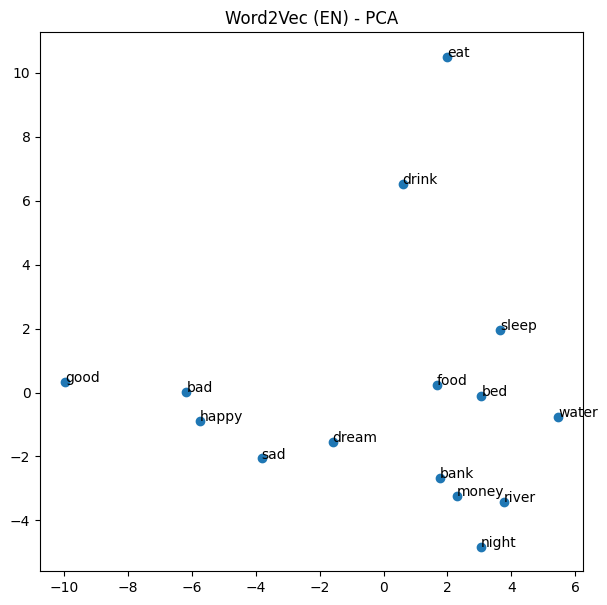

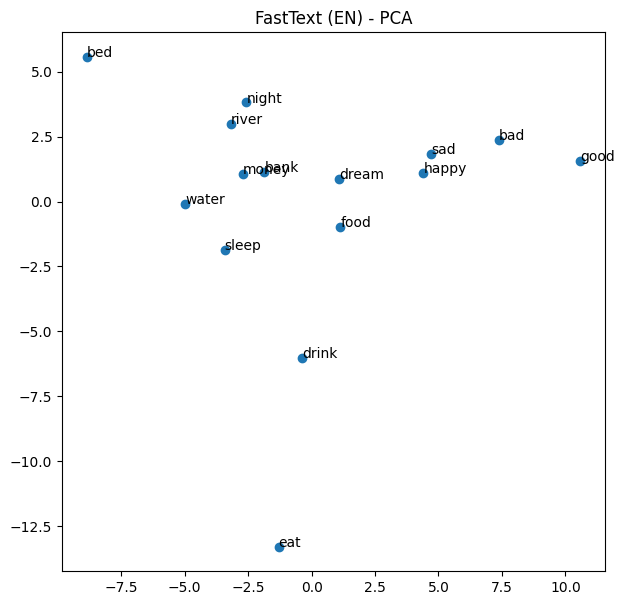

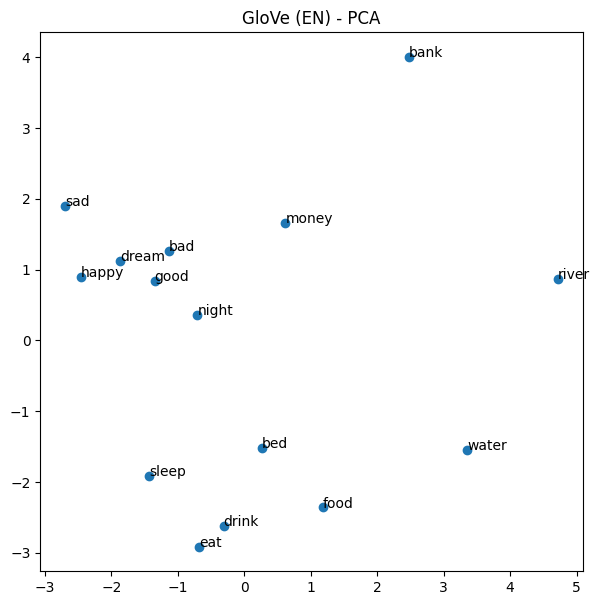

In [47]:
# Word2Vec English
plot_embeddings_2d(w2v_en, words_en, method="pca", title="Word2Vec (EN) - PCA")

# FastText English
plot_embeddings_2d(ft_en, words_en, method="pca", title="FastText (EN) - PCA")

# GloVe English
plot_embeddings_2d(glove, words_en, method="pca", title="GloVe (EN) - PCA")


## **Visualization**

In [48]:
import matplotlib.pyplot as plt

def plot_neighbors(model, word, topn=10, title=""):
    # get similar words
    if hasattr(model, "wv"):
        sims = model.wv.most_similar(word, topn=topn)
    else:
        sims = model.most_similar(word, topn=topn)

    words = [w for w, _ in sims]
    scores = [s for _, s in sims]

    plt.figure(figsize=(7,4))
    plt.barh(words[::-1], scores[::-1])
    plt.xlabel("Similarity")
    plt.title(title if title else f"Neighbors of '{word}'")
    plt.show()


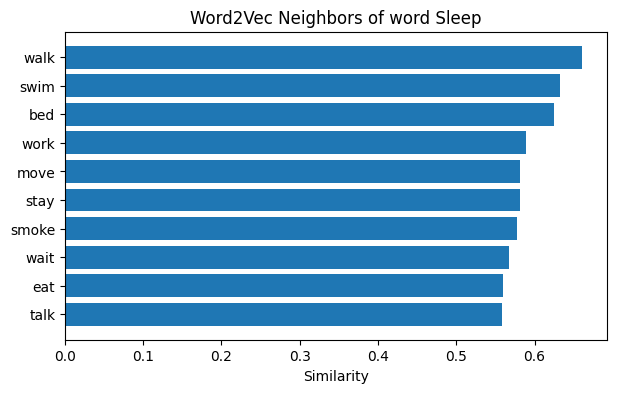

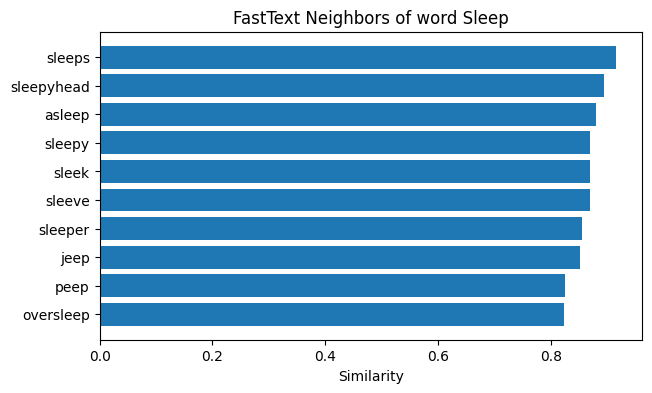

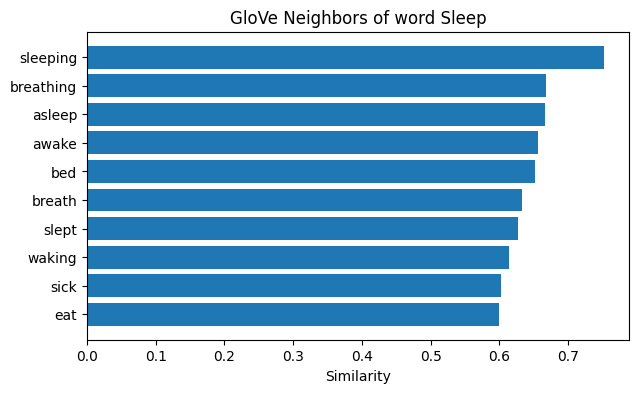

In [49]:
plot_neighbors(w2v_en, "sleep", 10, "Word2Vec Neighbors of word Sleep")

plot_neighbors(ft_en, "sleep", 10, "FastText Neighbors of word Sleep")

plot_neighbors(glove, "sleep", 10, "GloVe Neighbors of word Sleep")


## **OOV Handling of different embedding models**

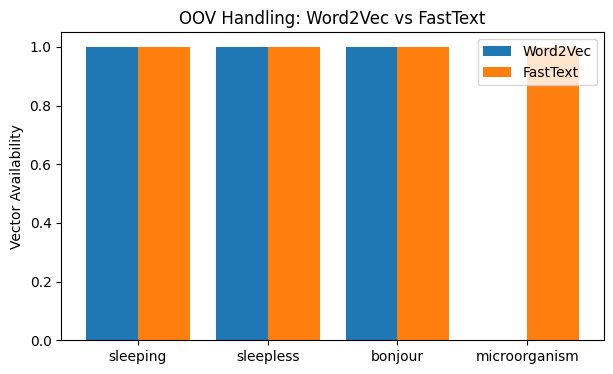

In [50]:
import matplotlib.pyplot as plt

test_words = ["sleeping", "sleepless", "bonjour", "microorganism"]

w2v_status = []
ft_status = []

for w in test_words:
    w2v_status.append(1 if w in w2v_en.wv else 0)

    try:
        _ = ft_en.wv[w]
        ft_status.append(1)
    except KeyError:
        ft_status.append(0)

x = range(len(test_words))

plt.figure(figsize=(7,4))
plt.bar(x, w2v_status, width=0.4, label="Word2Vec")
plt.bar([i+0.4 for i in x], ft_status, width=0.4, label="FastText")

plt.xticks([i+0.2 for i in x], test_words)
plt.ylabel("Vector Availability")
plt.title("OOV Handling: Word2Vec vs FastText")
plt.legend()
plt.show()


1 = vector available

0 = vector missing

FastText usually covers more words → better OOV handling. **Microorganism** word is not present in any of the datastes but fasttext can handle OOV words

# **Step 3 — Multiple Lingual Alignment**


To Compute a transformation matrix W that aligns English embeddings with French embeddings.

This makes:

W × English_vector ≈ French_vector

##**Using MUSE English–French dictionary**

## **3.1 Load Bilingual Dictionary (MUSE)**

In [51]:
# download MUSE English–French dictionary
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.txt


--2026-02-15 21:37:16--  https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.33, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857759 (1.8M) [text/x-c++]
Saving to: ‘en-fr.txt’

en-fr.txt           100%[===================>]   1.77M  --.-KB/s    in 0.06s   

2026-02-15 21:37:17 (27.6 MB/s) - ‘en-fr.txt’ saved [1857759/1857759]



In [52]:
pairs = []

with open("en-fr.txt", "r", encoding="utf-8") as f:
    for line in f:
        en, fr = line.strip().split()
        pairs.append((en.lower(), fr.lower()))

print("Total MUSE pairs:", len(pairs))


Total MUSE pairs: 113286


In [53]:
pairs = [
    (en, fr)
    for en, fr in pairs
    if en in ft_en.wv and fr in ft_fr.wv
]

print("Usable pairs:", len(pairs))


Usable pairs: 113286


## **3.2 Learn Alignment Matrix (W)**

In [54]:
import numpy as np
from scipy.linalg import orthogonal_procrustes

X, Y = [], []

for en, fr in pairs:
    X.append(ft_en.wv[en])
    Y.append(ft_fr.wv[fr])

X = np.array(X)
Y = np.array(Y)

W, _ = orthogonal_procrustes(X, Y)

print("Alignment matrix learned:", W.shape)


Alignment matrix learned: (100, 100)


## **3.3 Evaluate Alignment with Word Examples**

In [55]:
from numpy.linalg import norm

def cosine(a, b):
    return np.dot(a, b) / (norm(a) * norm(b))

test_words = ["sleep", "water", "friend", "food", "mother"]

for w in test_words:
    mapped = ft_en.wv[w] @ W
    fr_word, score = ft_fr.wv.similar_by_vector(mapped, topn=1)[0]
    print(f"{w} → {fr_word}  (similarity={score:.3f})")


sleep → s'endormir  (similarity=0.683)
water → froisser  (similarity=0.823)
friend → amidon  (similarity=0.814)
food → babeurre  (similarity=0.733)
mother → mariner  (similarity=0.783)


## **3.4 Quantitative Evaluation (Cosine Similarity Distribution)**

In [56]:
import numpy as np
from numpy.linalg import norm

def cosine(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b)))

# Use a sample of MUSE pairs to keep it fast (e.g., 5000)
eval_pairs = pairs[:20000]

sims = []
for en, fr in eval_pairs:
    mapped = ft_en.wv[en] @ W          # map EN -> FR space
    sim = cosine(mapped, ft_fr.wv[fr]) # cosine on the TRUE pair
    sims.append(sim)

print("Cosine similarity evaluation on MUSE pairs")
print("Pairs evaluated:", len(sims))
print("Mean cosine similarity:", np.mean(sims))
print("Median cosine similarity:", np.median(sims))
print("Min/Max:", np.min(sims), np.max(sims))


Cosine similarity evaluation on MUSE pairs
Pairs evaluated: 20000
Mean cosine similarity: 0.6923711551201778
Median cosine similarity: 0.7204748392105103
Min/Max: -0.4822649359703064 0.9725875854492188


## **3.5 Visualization of Alignment Quality**

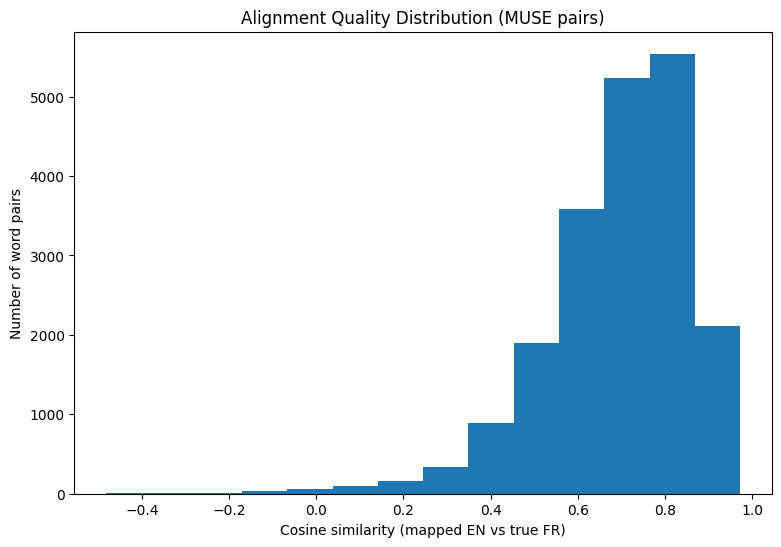

In [57]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,6))
plt.hist(sims, bins=14)
plt.xlabel("Cosine similarity (mapped EN vs true FR)")
plt.ylabel("Number of word pairs")
plt.title("Alignment Quality Distribution (MUSE pairs)")
plt.show()


# **4. Analysis of Embeddings**

#4.1 Visualization

## 4.1.1 Visualization (PCA) — English (before alignment)

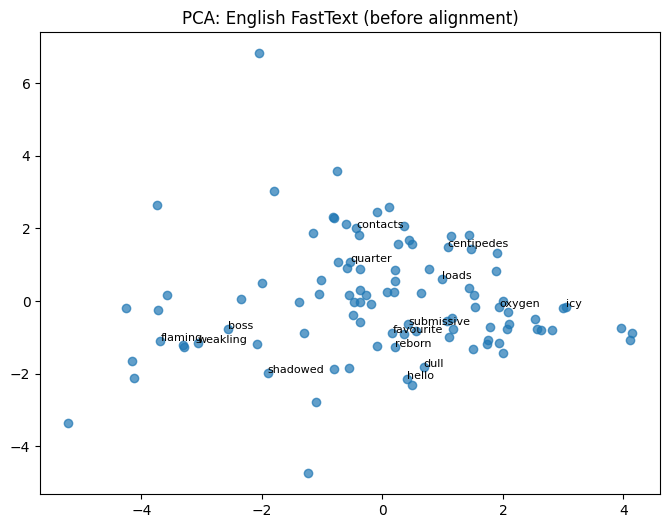

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

def pca_single_language(model_wv, n_points=200, seed=42, title="PCA"):
    random.seed(seed)
    vocab = model_wv.index_to_key
    words = random.sample(vocab, k=min(n_points, len(vocab)))
    X = np.vstack([model_wv[w] for w in words])

    coords = PCA(n_components=2, random_state=seed).fit_transform(X)

    plt.figure(figsize=(8,6))
    plt.scatter(coords[:,0], coords[:,1], alpha=0.7)
    for i in range(min(15, len(words))):  # label only a few
        plt.annotate(words[i], (coords[i,0], coords[i,1]), fontsize=8)
    plt.title(title)
    plt.show()

pca_single_language(ft_en.wv, n_points=100, title="PCA: English FastText (before alignment)")


## 4.1.2 Visualization (PCA) — French (before alignment)

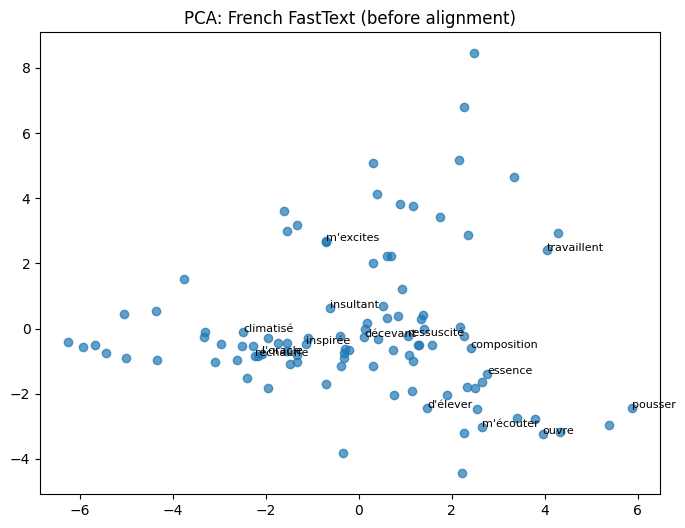

In [62]:
pca_single_language(ft_fr.wv, n_points=100, title="PCA: French FastText (before alignment)")


## 4.1.3 PCA — Shared Space (after alignment)

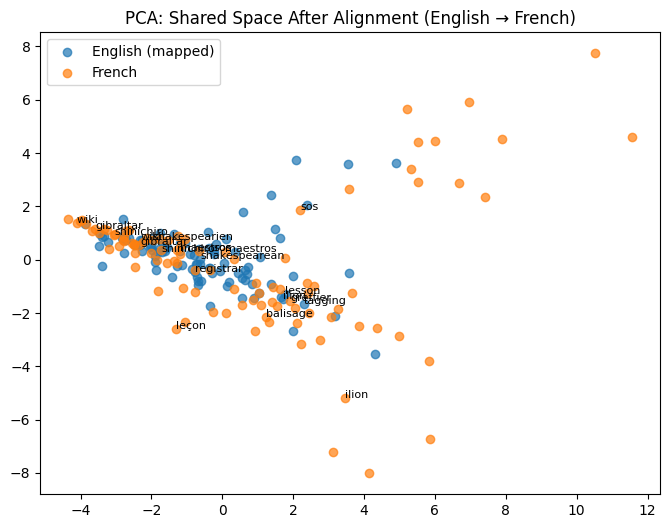

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random

def pca_aligned_shared(pairs, W, n_pairs=200, seed=42):
    random.seed(seed)
    sampled = random.sample(pairs, k=min(n_pairs, len(pairs)))

    en_words = [en for en, fr in sampled]
    fr_words = [fr for en, fr in sampled]

    # one space = French space
    en_vecs = np.vstack([ft_en.wv[en] @ W for en in en_words])  # EN mapped -> FR space
    fr_vecs = np.vstack([ft_fr.wv[fr] for fr in fr_words])      # FR original

    all_vecs = np.vstack([en_vecs, fr_vecs])
    coords = PCA(n_components=2, random_state=seed).fit_transform(all_vecs)

    en_coords = coords[:len(en_words)]
    fr_coords = coords[len(en_words):]

    plt.figure(figsize=(8,6))
    plt.scatter(en_coords[:,0], en_coords[:,1], label="English (mapped)", alpha=0.7)
    plt.scatter(fr_coords[:,0], fr_coords[:,1], label="French", alpha=0.7)

    # label only a few pairs
    for i in range(min(10, len(en_words))):
        plt.annotate(en_words[i], (en_coords[i,0], en_coords[i,1]), fontsize=8)
        plt.annotate(fr_words[i], (fr_coords[i,0], fr_coords[i,1]), fontsize=8)

    plt.title("PCA: Shared Space After Alignment (English → French)")
    plt.legend()
    plt.show()

pca_aligned_shared(pairs, W, n_pairs=100)


## **4.2 Synonyms & Antonyms (within each language)**

## Show embeddings place similar words close and opposite words differently.

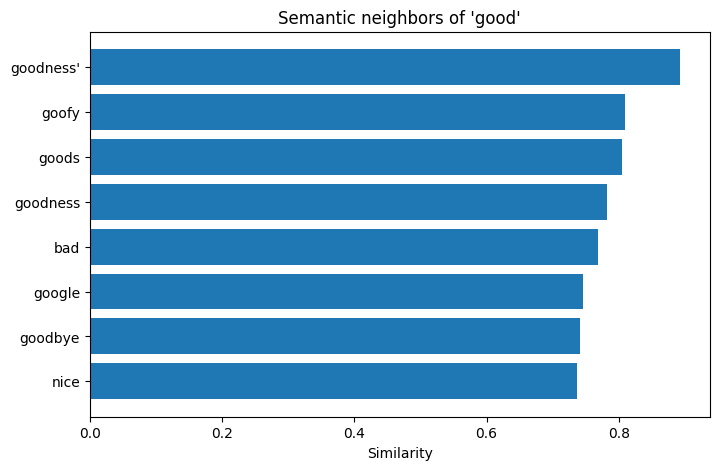

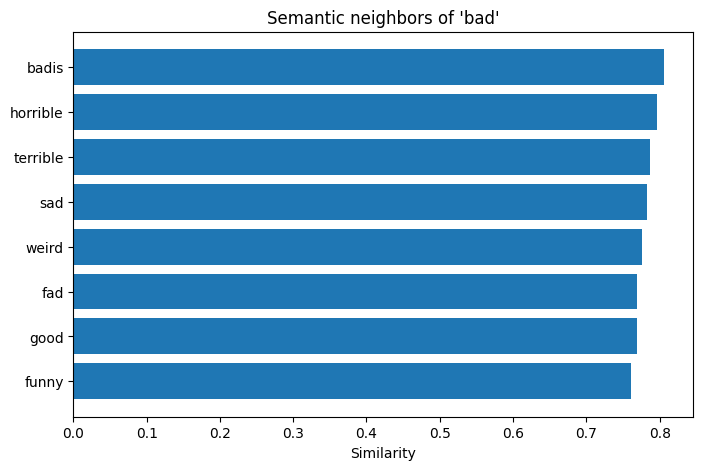

In [64]:
import matplotlib.pyplot as plt

def plot_neighbors(model, word, topn=8, title=""):
    neighbors = model.wv.most_similar(word, topn=topn)
    words = [w for w, _ in neighbors]
    scores = [s for _, s in neighbors]

    plt.figure(figsize=(8,5))
    plt.barh(words[::-1], scores[::-1])
    plt.xlabel("Similarity")
    plt.title(title if title else f"Neighbors of '{word}'")
    plt.show()

# visualize
plot_neighbors(ft_en, "good", title="Semantic neighbors of 'good'")
plot_neighbors(ft_en, "bad", title="Semantic neighbors of 'bad'")


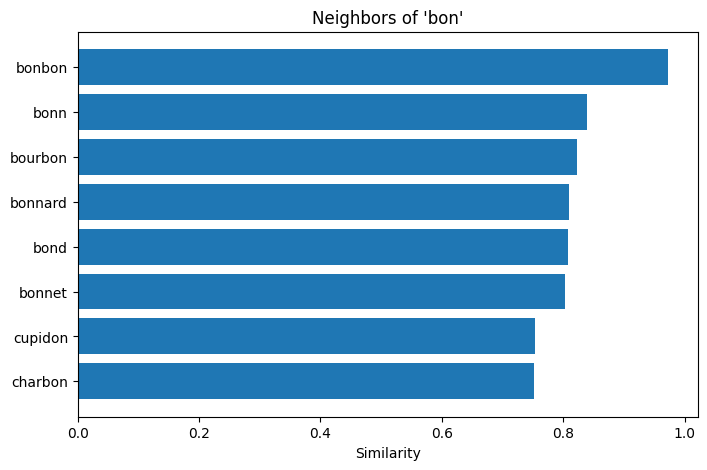

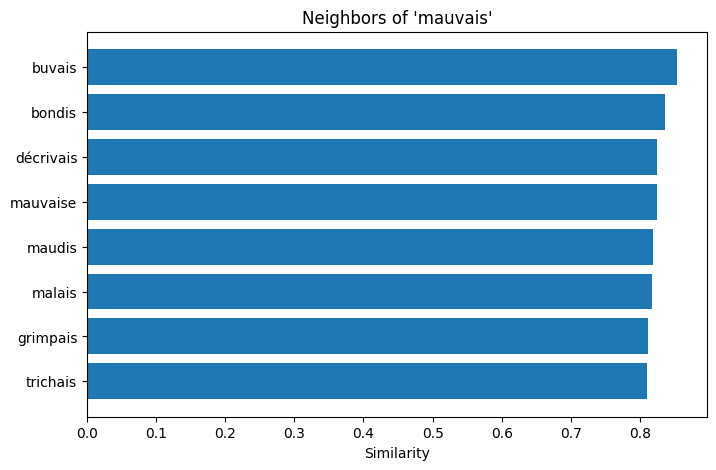

In [65]:
plot_neighbors(ft_fr, "bon")
plot_neighbors(ft_fr, "mauvais")


## English embeddings show meaningful semantic structure, with sentiment-related neighbors appearing near good and bad, though some morphological variants and unrelated words appear due to corpus noise and subword similarity.
##French neighbors are dominated by spelling and morphological similarity rather than pure semantics, reflecting FastText’s subword modeling and the more limited or noisy training data.

## **Step 4.3 - Analysis**

In [67]:
# ============================================================
# Step 4 — Analysis: synonyms/antonyms, common words,
# polysemy, OOV coverage, and nearest neighbors
# Works with: FastText + MUSE dictionary + Procrustes W
# ============================================================

import numpy as np
from numpy.linalg import norm
from collections import Counter

# ---------- Inputs ----------
# ft_en : gensim FastText model for English
# ft_fr : gensim FastText model for French
# W     : (d,d) alignment matrix EN->FR learned by orthogonal_procrustes
# pairs : list of (en_word, fr_word) usable MUSE pairs (already filtered)
# en_tokenized, fr_tokenized : list[list[str]] tokenized sentences
# ------------------------------------------------------------------

def cosine(a, b):
    return float(np.dot(a, b) / (norm(a) * norm(b) + 1e-12))

def map_en_to_fr(vec_en):
    # vec_en is shape (d,)
    return vec_en @ W

def nearest_in_fr(mapped_vec, top_k=5):
    # gensim expects a vector in FR space
    return ft_fr.wv.similar_by_vector(mapped_vec, topn=top_k)

def analyze_synonyms_antonyms(model, syn_pairs, ant_pairs):
    syn_sims, ant_sims = [], []
    for a, b in syn_pairs:
        if a in model.wv and b in model.wv:
            syn_sims.append(cosine(model.wv[a], model.wv[b]))
    for a, b in ant_pairs:
        if a in model.wv and b in model.wv:
            ant_sims.append(cosine(model.wv[a], model.wv[b]))
    return {
        "mean_synonym_similarity": float(np.mean(syn_sims)) if syn_sims else None,
        "mean_antonym_similarity": float(np.mean(ant_sims)) if ant_sims else None,
        "synonym_antonym_gap": (float(np.mean(syn_sims) - np.mean(ant_sims))
                                  if syn_sims and ant_sims else None),
        "n_syn_pairs_used": len(syn_sims),
        "n_ant_pairs_used": len(ant_sims)
    }

def analyze_common_words(ft_en, ft_fr, W, word_pairs, n_eval=500):
    # Evaluate average cosine between mapped EN vectors and true FR vectors
    sims = []
    used = 0
    for en, fr in word_pairs[:n_eval]:
        if en in ft_en.wv and fr in ft_fr.wv:
            v = map_en_to_fr(ft_en.wv[en])
            sims.append(cosine(v, ft_fr.wv[fr]))
            used += 1
    return {"mean_cosine": float(np.mean(sims)) if sims else None, "n_pairs": used}

def analyze_polysemy(model, target_word, context_words):
    # simple proxy: similarity(target, context_i) for each context cue
    # (Word2Vec/FastText are single-sense; this will often be "mixed")
    out = []
    if target_word not in model.wv:
        return {"word": target_word, "error": "target not in vocab"}
    for label, cue in context_words:
        if cue in model.wv:
            out.append({
                "sense": label,
                "example": cue,
                "similarity": cosine(model.wv[target_word], model.wv[cue])
            })
    return {"word": target_word, "sense_similarities": out}

def oov_coverage(token_lists, vocab_sets):
    # token_lists: list[list[str]]
    # vocab_sets: dict[name -> set(words)]
    flat = [t for sent in token_lists for t in sent]
    total = len(flat)
    counts = Counter(flat)
    unique = list(counts.keys())
    res = {"total_tokens": total, "unique_tokens": len(unique)}
    for name, vocab in vocab_sets.items():
        covered = sum(counts[w] for w in unique if w in vocab)
        res[f"{name}_coverage"] = covered / (total + 1e-12)
    return res

## **4.4 Synonyms vs Antonyms**

In [68]:
# ------------------ 4.1 Synonyms vs Antonyms (English) ------------------
syn_pairs = [("good","great"), ("big","large"), ("happy","joyful")]
ant_pairs = [("good","bad"), ("big","small"), ("happy","sad")]

syn_ant = analyze_synonyms_antonyms(ft_en, syn_pairs, ant_pairs)
print("Synonyms vs Antonyms (EN, FastText):", syn_ant)

Synonyms vs Antonyms (EN, FastText): {'mean_synonym_similarity': 0.7144039273262024, 'mean_antonym_similarity': 0.769291877746582, 'synonym_antonym_gap': -0.05488795042037964, 'n_syn_pairs_used': 3, 'n_ant_pairs_used': 3}


## **4.5 Similar words in English space**

In [69]:

# ------------------ 4.2 Similar words in English space ------------------
for w in ["love", "water", "book"]:
    if w in ft_en.wv:
        print(f"\nSimilar to '{w}' (EN):", ft_en.wv.most_similar(w, topn=5))
    else:
        print(f"\n'{w}' not in EN vocab (FastText usually still covers it).")


Similar to 'love' (EN): [('glove', 0.9244005680084229), ('lovesickness', 0.8306993842124939), ('jove', 0.7868183851242065), ('lover', 0.7852515578269958), ('hate', 0.7793198823928833)]

Similar to 'water' (EN): [('tapwater', 0.9658058285713196), ('bathwater', 0.9641621708869934), ('seawater', 0.9599974155426025), ('freshwater', 0.9479736685752869), ('waterloo', 0.9253734946250916)]

Similar to 'book' (EN): [('bookworm', 0.9557055830955505), ('textbook', 0.9273257255554199), ('bookcase', 0.9269275665283203), ('guidebook', 0.9254382252693176), ('bookshop', 0.9241059422492981)]


## **4.6 Common words using aligned space**

In [70]:
# ------------------ 4.3 Common words (EN-FR translations) using aligned space ------------------
# Use the same 'pairs' list from MUSE as "common translations"
common_metrics = analyze_common_words(ft_en, ft_fr, W, pairs, n_eval=500)
print("\nCommon words (aligned EN->FR):", common_metrics)

# Show a few translation examples (nearest FR neighbors after mapping)
test_words = ["sleep", "water", "friend", "food", "mother"]
print("\nNearest FR translations after mapping:")
for w in test_words:
    if w in ft_en.wv:
        mapped = map_en_to_fr(ft_en.wv[w])
        print(f"  {w:>8s} -> {nearest_in_fr(mapped, top_k=5)}")
    else:
        print(f"  {w:>8s} -> (OOV in EN vocab)")


Common words (aligned EN->FR): {'mean_cosine': 0.5549345780927688, 'n_pairs': 500}

Nearest FR translations after mapping:
     sleep -> [("s'endormir", 0.682503879070282), ('dormira', 0.6781022548675537), ('dormirai', 0.673492431640625), ('couchera', 0.6707471013069153), ("t'endors", 0.6676445603370667)]
     water -> [('froisser', 0.8228990435600281), ('bouleverser', 0.8175064325332642), ('plancher', 0.814534068107605), ('blanchir', 0.8134760856628418), ('balancer', 0.8086368441581726)]
    friend -> [('amidon', 0.8138764500617981), ('amiral', 0.7999327182769775), ('amie', 0.7986855506896973), ('vietnamien', 0.7815637588500977), ('amitié', 0.7811033129692078)]
      food -> [('babeurre', 0.7327429056167603), ('beurre', 0.7254040837287903), ('chocolatine', 0.724415123462677), ('chèvre', 0.7226337194442749), ('cholestérol', 0.7177160382270813)]
    mother -> [('mariner', 0.7828304767608643), ('marier', 0.7819132208824158), ('familiariser', 0.7786333560943604), ('chatouiller', 0.778148

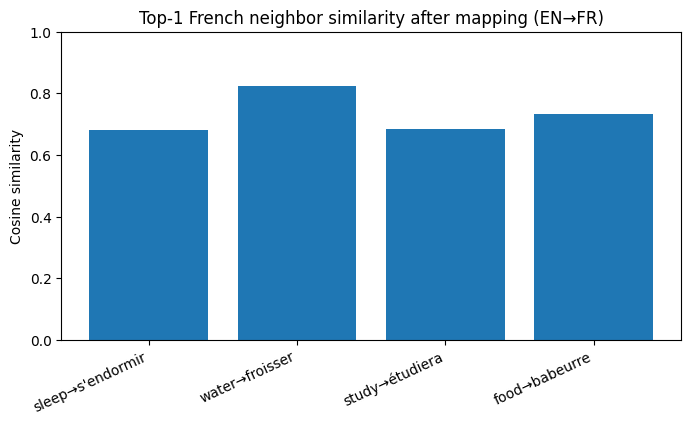

In [82]:
import matplotlib.pyplot as plt

test_words = ["sleep", "water", "study", "food"]

labels, scores = [], []
for w in test_words:
    if w in ft_en.wv:
        mapped = map_en_to_fr(ft_en.wv[w])
        fr_word, score = ft_fr.wv.similar_by_vector(mapped, topn=1)[0]
        labels.append(f"{w}→{fr_word}")
        scores.append(score)
    else:
        labels.append(f"{w}→OOV")
        scores.append(0.0)

plt.figure(figsize=(8,4))
plt.bar(labels, scores)
plt.xticks(rotation=25, ha="right")
plt.title("Top-1 French neighbor similarity after mapping (EN→FR)")
plt.ylabel("Cosine similarity")
plt.ylim(0, 1.0)
plt.show()


## **4.7 Polysemy proxy**

In [83]:
# ------------------ 4.4 Polysemy proxy ------------------
poly = analyze_polysemy(ft_en, "bank", [("financial","money"), ("river","water"), ("financial","account")])
print("\nPolysemy (bank):", poly)



Polysemy (bank): {'word': 'bank', 'sense_similarities': [{'sense': 'financial', 'example': 'money', 'similarity': 0.5522430539131165}, {'sense': 'river', 'example': 'water', 'similarity': 0.630246102809906}, {'sense': 'financial', 'example': 'account', 'similarity': 0.5915284752845764}]}


## **4.8 OOV Coverage**

In [84]:
# ------------------ 4.5 OOV Coverage (EN+FR tokens) ------------------
# FastText has subword, but gensim still has a vocab set; coverage here measures "in vocab list".
# You can add glove/word2vec sets if you loaded them.
en_tokenized = english_tokens
fr_tokenized = french_tokens
token_lists_all = en_tokenized.to_list() + fr_tokenized.to_list()

vocab_sets = {
    "fasttext": set(ft_en.wv.key_to_index.keys()) | set(ft_fr.wv.key_to_index.keys())
}
oov = oov_coverage(token_lists_all, vocab_sets)
print("\nOOV coverage:", oov)


OOV coverage: {'total_tokens': 5764122, 'unique_tokens': 80202, 'fasttext_coverage': 0.9949267208431744}


# Step 5 - Visualizations (PCA, t-SNE- Multilingual PCA)

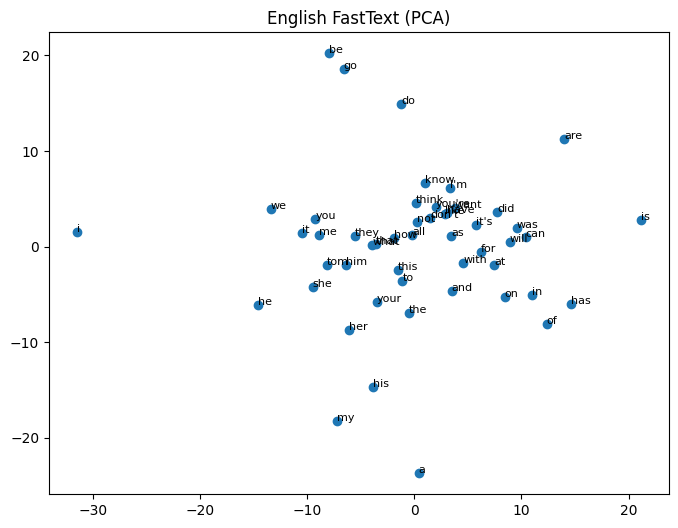

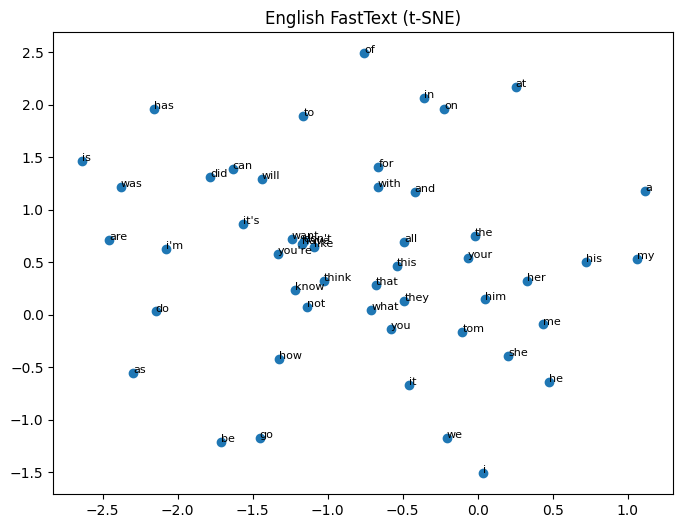

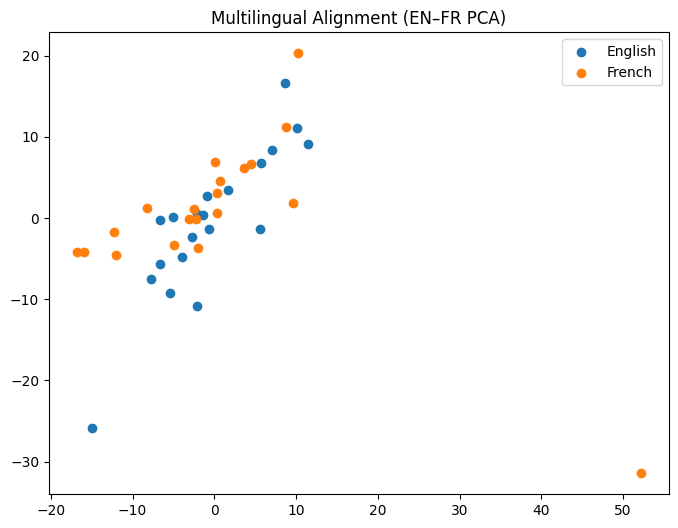

In [85]:
# ============================================
# Step 5 — Visualization
# PCA + t-SNE + Multilingual alignment
# ============================================

# This code visualizes semantic structure and verifies cross-lingual alignment by projecting English and French word embeddings into a shared 2D space.
# Selects frequent words: Finds most common English & French words in the corpus. Keeps only those present in the embedding vocabulary. Ensures meaningful, representative words.
# Plots English embeddings (PCA): Reduces high-dimensional vectors → 2D using PCA. Displays semantic structure. Shows how similar words cluster.
# Plots English embeddings (t-SNE): Creates tight clusters based on similarity. Highlights semantic neighborhoods. Shows fine-grained relationships.
# Maps English vectors → French space: mapped_vec = vec @ W. Applies alignment matrix W. Moves English words into the French embedding space. Enables cross-lingual comparison.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter

# ---------- Select frequent words ----------
all_en = [w for s in en_tokenized for w in s]
all_fr = [w for s in fr_tokenized for w in s]

top_en = [w for w,_ in Counter(all_en).most_common(80) if w in ft_en.wv]
top_fr = [w for w,_ in Counter(all_fr).most_common(80) if w in ft_fr.wv]

words_en = top_en[:50]
vecs_en = np.array([ft_en.wv[w] for w in words_en])

# ---------- PCA EN ----------
pca = PCA(n_components=2)
coords = pca.fit_transform(vecs_en)

plt.figure(figsize=(8,6))
plt.scatter(coords[:,0], coords[:,1])
for i,w in enumerate(words_en):
    plt.text(coords[i,0], coords[i,1], w, fontsize=8)
plt.title("English FastText (PCA)")
plt.show()


# ---------- t-SNE EN ----------
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords_tsne = tsne.fit_transform(vecs_en)

plt.figure(figsize=(8,6))
plt.scatter(coords_tsne[:,0], coords_tsne[:,1])
for i,w in enumerate(words_en):
    plt.text(coords_tsne[i,0], coords_tsne[i,1], w, fontsize=8)
plt.title("English FastText (t-SNE)")
plt.show()


# ---------- Multilingual PCA (alignment quality) ----------
def map_en(vec):
    return vec @ W

en_viz = words_en[:20]
fr_viz = top_fr[:20]

en_vecs = np.array([map_en(ft_en.wv[w]) for w in en_viz])
fr_vecs = np.array([ft_fr.wv[w] for w in fr_viz])

combined = np.vstack([en_vecs, fr_vecs])
coords_multi = PCA(n_components=2).fit_transform(combined)

plt.figure(figsize=(8,6))
plt.scatter(coords_multi[:len(en_viz),0], coords_multi[:len(en_viz),1], label="English")
plt.scatter(coords_multi[len(en_viz):,0], coords_multi[len(en_viz):,1], label="French")

plt.legend()
plt.title("Multilingual Alignment (EN–FR PCA)")
plt.show()


# **Step 6 — Downstream task: Language Identification (EN vs FR)**


### Train a multilingual classifier to identify the language of a sentence (EN vs FR) using aligned embeddings.

In [86]:
# Step 6 — Downstream task: Language Identification (EN vs FR)
# Using aligned sentence embeddings in shared space (FR space)
# builds sentence embeddings by averaging word vectors
# maps EN sentences into FR space using W (so both are in same space)
# trains LogisticRegression + prints report

# Note (so it matches the assignment logic)
# We must align before classification, otherwise it becomes trivial if EN and FR live in separate spaces.
# Here, both EN & FR sentence vectors are in the same FR space:
# EN sentence avg → mapped using W
# FR sentence avg → stays as is

import numpy as np
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import json

# ---------- helpers ----------
def sent_embedding(tokens, model, dim, fallback="zeros"):
    """Average word vectors for tokens that exist in model.wv."""
    vecs = []
    for w in tokens:
        if w in model.wv:
            vecs.append(model.wv[w])
    if len(vecs) == 0:
        return np.zeros(dim, dtype=np.float32) if fallback == "zeros" else None
    return np.mean(vecs, axis=0).astype(np.float32)

def map_en_sent_to_fr_space(v_en):
    return (v_en @ W).astype(np.float32)

# ---------- build X, y ----------
dim = ft_en.wv.vector_size  # should match ft_fr

# Optional: limit samples for speed in Colab
MAX_SENTS_PER_LANG = None  # e.g. 50000 for faster run, or None for all

en_sents = en_tokenized[:MAX_SENTS_PER_LANG] if MAX_SENTS_PER_LANG else en_tokenized
fr_sents = fr_tokenized[:MAX_SENTS_PER_LANG] if MAX_SENTS_PER_LANG else fr_tokenized

X_en = []
for s in en_sents:
    v = sent_embedding(s, ft_en, dim)
    X_en.append(map_en_sent_to_fr_space(v))   # map EN -> FR space

X_fr = []
for s in fr_sents:
    v = sent_embedding(s, ft_fr, dim)
    X_fr.append(v)                            # already in FR space

X = np.vstack([np.vstack(X_en), np.vstack(X_fr)])
y = np.array([0]*len(X_en) + [1]*len(X_fr))   # 0=en, 1=fr

print("Language ID data:", "X", X.shape, "y", y.shape)

# ---------- train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- train classifier ----------
clf = LogisticRegression(max_iter=2000, n_jobs=-1)
clf.fit(X_train, y_train)

# ---------- evaluate ----------
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", pos_label=1)

metrics = {
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1": float(f1)
}

print("Metrics:", metrics)
print("\nClassification Report (0=en, 1=fr):")
print(classification_report(y_test, y_pred, target_names=["en","fr"]))

# ---------- save results_summary.json ----------
# If you already computed these earlier in Colab, keep them;
# otherwise set them to None to avoid NameError.
results_summary = {
    "alignment_metrics": globals().get("alignment_metrics", None),
    "synonym_antonym": globals().get("syn_ant", None),
    "common_words": globals().get("common_metrics", None),
    "polysemy": globals().get("poly", None),
    "oov_coverage": globals().get("oov", None),
    "classifier_metrics": metrics
}

OUT_PATH = "results_summary.json"
with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(results_summary, f, indent=2)

print(f"\nSaved: {OUT_PATH}")


Language ID data: X (858742, 100) y (858742,)
Metrics: {'accuracy': 0.9823521534332078, 'precision': 0.982908772952492, 'recall': 0.9817756247525444, 'f1': 0.9823418720761554}

Classification Report (0=en, 1=fr):
              precision    recall  f1-score   support

          en       0.98      0.98      0.98     85875
          fr       0.98      0.98      0.98     85874

    accuracy                           0.98    171749
   macro avg       0.98      0.98      0.98    171749
weighted avg       0.98      0.98      0.98    171749


Saved: results_summary.json


In [87]:
samples = [
    ("I love machine learning.", "en"),
    ("Bonjour, comment allez-vous ?", "fr"),
    ("This project is interesting.", "en"),
    ("Je suis étudiant à Lyon.", "fr"),
    ("je m'appelle Adam", "fr"),
    ("I love Natural Lanugage Processing", "en"),
]

def predict_lang(text, true_lang):
    tokens = text.lower().split()

    if true_lang == "en":
        v = sent_embedding(tokens, ft_en, dim)
        v = map_en_sent_to_fr_space(v)   # EN -> FR space
    else:
        v = sent_embedding(tokens, ft_fr, dim)  # already in FR space

    pred = clf.predict([v])[0]
    return "en" if pred == 0 else "fr"

for text, true_lang in samples:
    pred = predict_lang(text, true_lang)
    print(f"{text}  | true={true_lang}  pred={pred}")


I love machine learning.  | true=en  pred=en
Bonjour, comment allez-vous ?  | true=fr  pred=en
This project is interesting.  | true=en  pred=en
Je suis étudiant à Lyon.  | true=fr  pred=fr
je m'appelle Adam  | true=fr  pred=fr
I love Natural Lanugage Processing  | true=en  pred=en


<Figure size 400x400 with 0 Axes>

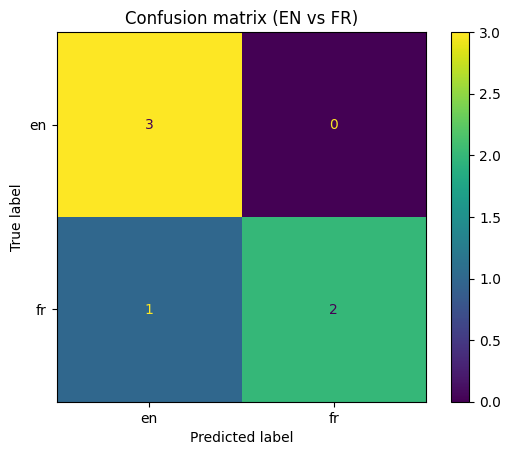

In [90]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.array([0 if lang=="en" else 1 for _,lang in samples])
y_pred = clf.predict(X_demo)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["en","fr"])

plt.figure(figsize=(4,4))
disp.plot(values_format="d")
plt.title("Confusion matrix (EN vs FR)")
plt.show()
